In [124]:
library(modelr)
library(tidyverse)
library(lubridate)
theme_set(theme_minimal())

# Lecture 21: Model building and comparison

In this lecture we'll look at:
- [Building models](http://r4ds.had.co.nz/model-building.html)
- How to compare [many models](http://r4ds.had.co.nz/many-models.html)

# Building models
In practice we progressively build up models until we feel like it has captured most of the patterns in the data.

Earlier in the course we studied the `diamonds` data set. We found that there was an unexpected relationship between cut, clarity, and price:

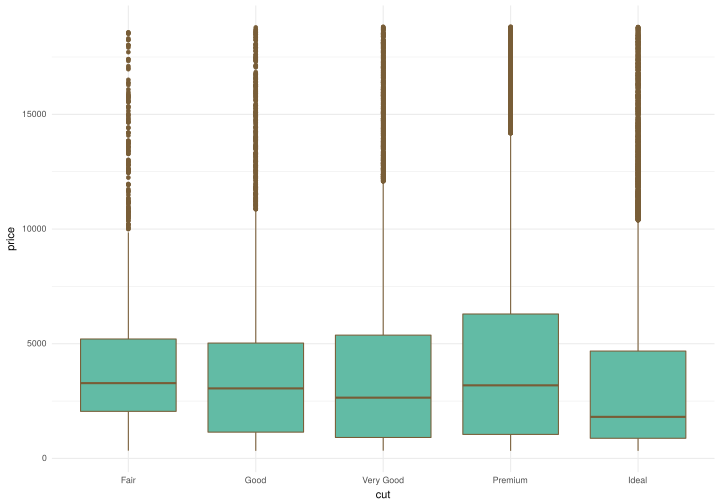

In [125]:
ggplot(diamonds, aes(cut, price)) + geom_boxplot()

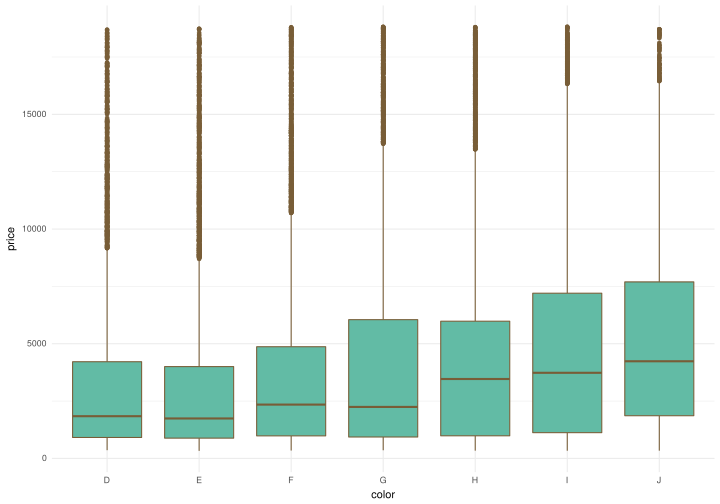

In [126]:
ggplot(diamonds, aes(color, price)) + geom_boxplot()

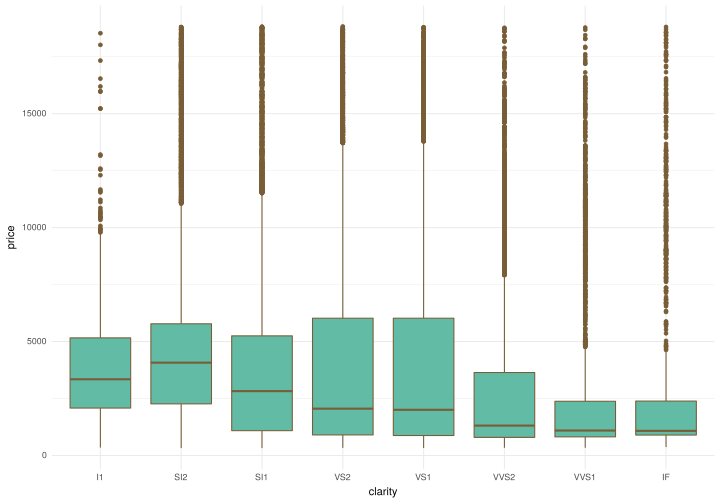

In [127]:
ggplot(diamonds, aes(clarity, price)) + geom_boxplot()

Surprisingly, there is a clear negative association between quality and price: higher quality diamonds seem to have a lower price. We reasoned that this is because of a confounder: the weight of the diamond is the single most important factor for determining the price of the diamond, and lower quality diamonds tend to be larger.

A plot of carat vs. price confirms this:

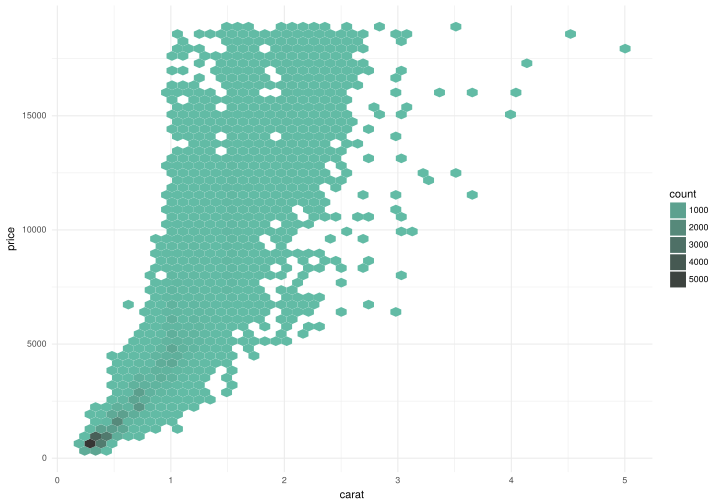

In [128]:
ggplot(diamonds, aes(carat, price)) + 
  geom_hex(bins = 50)

We argued that log-transforming the data makes the relationship approximately linear. Also, we are going to drop the upper ~0.3% of heaviest diamonds by restricting to `carat < 2.5`:

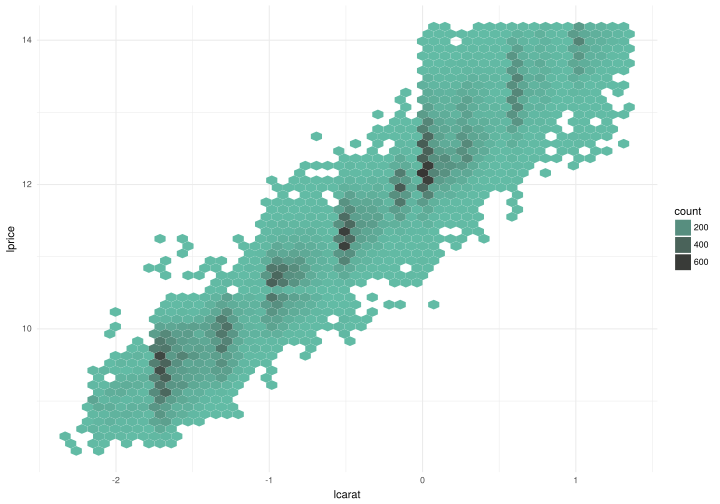

In [129]:
diamonds2 = diamonds %>% filter(carat <= 2.5) %>% 
                         mutate(lprice = log2(price), lcarat = log2(carat))
ggplot(diamonds2, aes(lcarat, lprice)) + geom_hex(bins = 50)

Now the data are in good shape to fit a linear model:

In [164]:
mod_diamond = lm(lprice ~ lcarat, data = diamonds2)
summary(mod_diamond)


Call:
lm(formula = lprice ~ lcarat, data = diamonds2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.96407 -0.24549 -0.00844  0.23930  1.93486 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.193863   0.001969  6194.5   <2e-16 ***
lcarat       1.681371   0.001936   868.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3767 on 53812 degrees of freedom
Multiple R-squared:  0.9334,	Adjusted R-squared:  0.9334 
F-statistic: 7.542e+05 on 1 and 53812 DF,  p-value: < 2.2e-16


In the original, untransformed space we get:

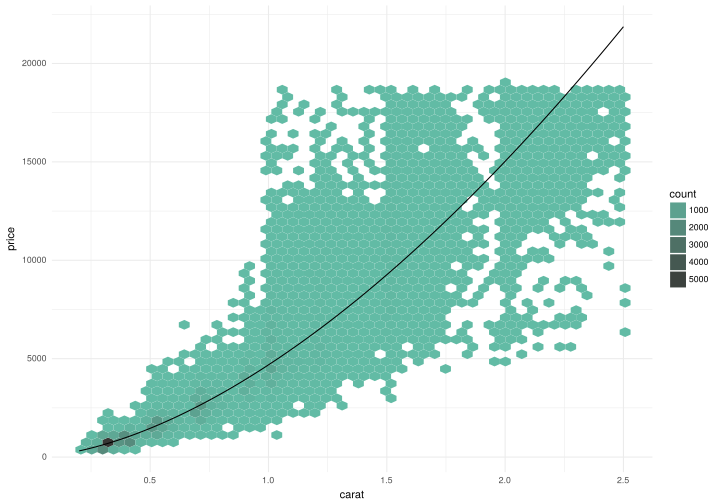

In [166]:
add_predictions(diamonds2, mod_diamond) %>% ggplot(aes(carat, price)) + 
    geom_hex(bins = 50) + geom_line(aes(y = 2 ** pred), colour = "black")

For large diamonds (`carat` > 2, say) there are many more observations *below* the regression line than above it. So the model predicts much higher prices for the large diamonds than are actually observed.

Turning to the residuals, we see that they look largely random, with no remaining discernible patterns. 

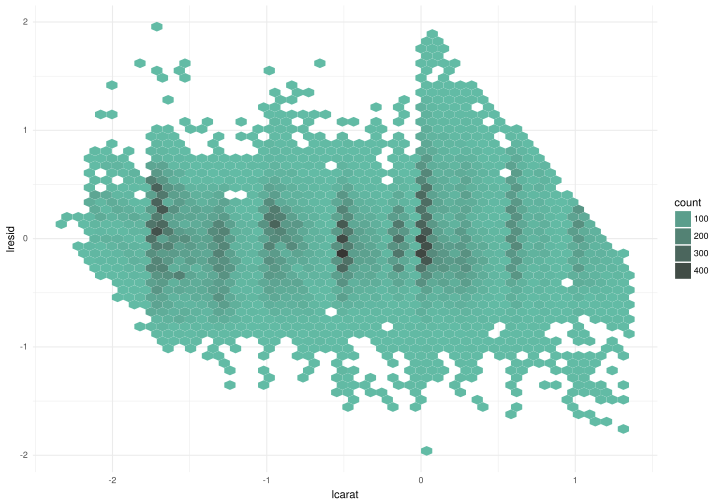

In [167]:
diamonds2 = diamonds2 %>% add_residuals(mod_diamond, "lresid")
ggplot(diamonds2, aes(lcarat, lresid)) + geom_hex(bins = 50)

The residuals represent the component of price that is not explained by the size of the diamond. We expect that this has something to do with the diamonds *quality*. To confirm this, we can repeat the same plots as above, this time using the residual in place of the price itself:

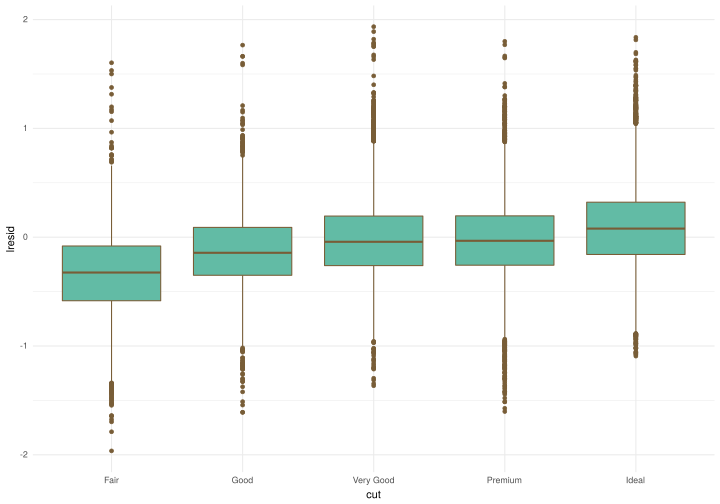

In [133]:
ggplot(diamonds2, aes(cut, lresid)) + geom_boxplot()

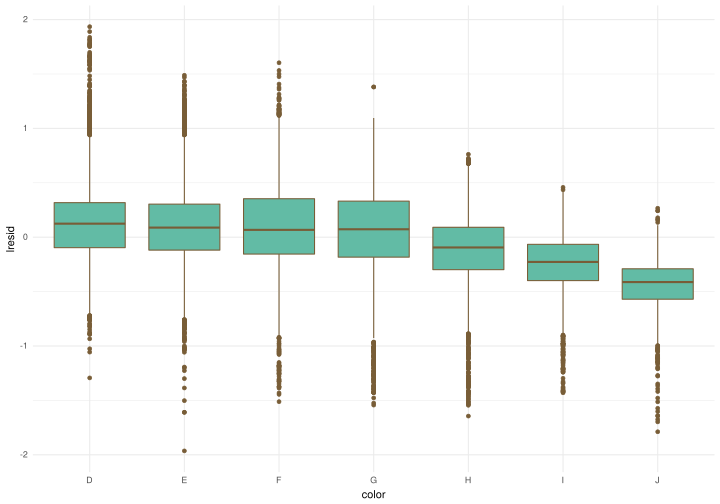

In [134]:
ggplot(diamonds2, aes(color, lresid)) + geom_boxplot()

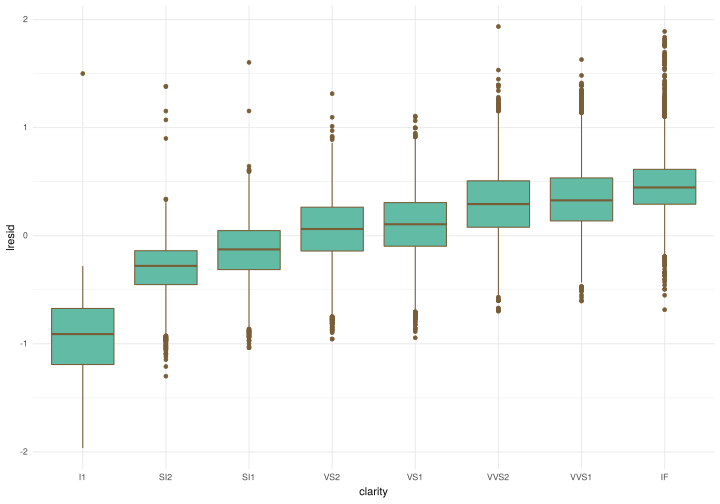

In [135]:
ggplot(diamonds2, aes(clarity, lresid)) + geom_boxplot()

These plots indicate the relationship that we would expect: Now we see the relationship we expect: as the quality of the diamond increases, so does its price.

Given that the residuals still contain obvious patterns, we could go ahead and build up a more complex model which includes these additional attributes as predictors:

In [168]:
mod_diamond2 = lm(lprice ~ lcarat + cut + color + clarity, data = diamonds2)
summary(mod_diamond2)


Call:
lm(formula = lprice ~ lcarat + cut + color + clarity, data = diamonds2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.17388 -0.12437 -0.00094  0.11920  2.78322 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 12.206978   0.001693 7211.806  < 2e-16 ***
lcarat       1.886239   0.001124 1677.809  < 2e-16 ***
cut.L        0.173866   0.003386   51.349  < 2e-16 ***
cut.Q       -0.050346   0.002980  -16.897  < 2e-16 ***
cut.C        0.019129   0.002583    7.407 1.31e-13 ***
cut^4       -0.002410   0.002066   -1.166    0.243    
color.L     -0.633998   0.002910 -217.872  < 2e-16 ***
color.Q     -0.137580   0.002676  -51.409  < 2e-16 ***
color.C     -0.022072   0.002503   -8.819  < 2e-16 ***
color^4      0.016570   0.002297    7.213 5.54e-13 ***
color^5     -0.002828   0.002169   -1.304    0.192    
color^6      0.003533   0.001971    1.793    0.073 .  
clarity.L    1.308155   0.005179  252.598  < 2e-16 ***
clarity.Q   -0.334090   0.004839

Now to generate predictions we are required to specify four pieces of information: the (log) weight, color, cut and clarity. To examine the relationship between the prediction and one of these variables, it helps to set the remaining variables to their "typical" values (something like the median in the case of a continuous variable, or mode in the case of a discrete variable.)

In [170]:
grid = diamonds2 %>% data_grid(cut, lcarat = -0.515, color = "G", clarity = "SI1") %>%
                     add_predictions(mod_diamond2) %>% print

# A tibble: 5 x 5
  cut       lcarat color clarity  pred
  <ord>      <dbl> <chr> <chr>   <dbl>
1 Fair      -0.515 G     SI1      11.0
2 Good      -0.515 G     SI1      11.1
3 Very Good -0.515 G     SI1      11.2
4 Premium   -0.515 G     SI1      11.2
5 Ideal     -0.515 G     SI1      11.2


For typical values of the remaining predictors, we see the expected relationship between cut and the predicted
log price:

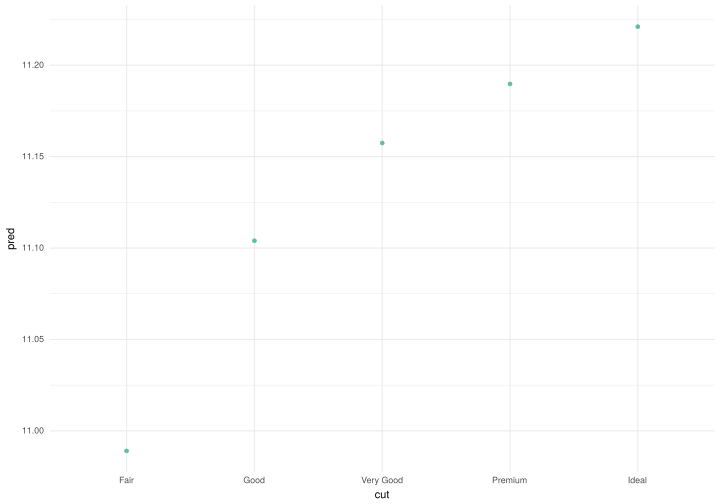

In [171]:
ggplot(grid, aes(cut, pred)) + geom_point()

## Factors affecting flights
Let's try building up a model that explains the number of flights leaving from NYC airports each day.

In [172]:
library(nycflights13)
daily = flights %>% mutate(date = make_date(year, month, day)) %>% count(date) %>% print

# A tibble: 365 x 2
   date           n
   <date>     <int>
 1 2013-01-01   842
 2 2013-01-02   943
 3 2013-01-03   914
 4 2013-01-04   915
 5 2013-01-05   720
 6 2013-01-06   832
 7 2013-01-07   933
 8 2013-01-08   899
 9 2013-01-09   902
10 2013-01-10   932
# ... with 355 more rows


As we have already seen, there is a strong daily component to flights, as well as weaker monthly and seasonal effects:

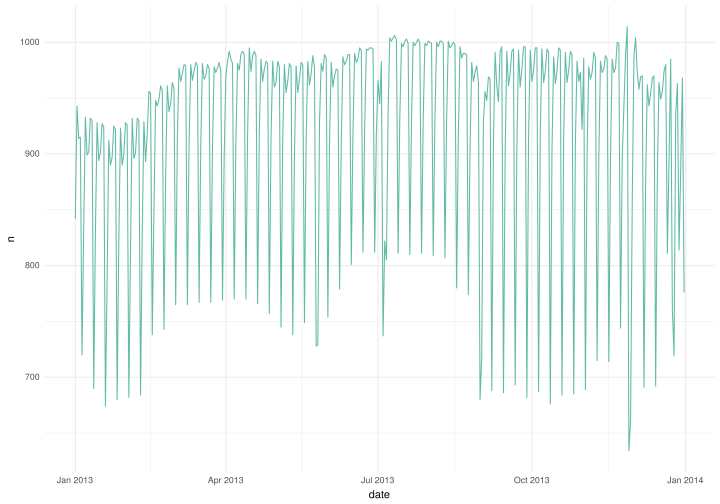

In [173]:
ggplot(daily, aes(x = date, y = n)) + geom_line()

The most obvious pattern is a day-of-the-week effect. For example:

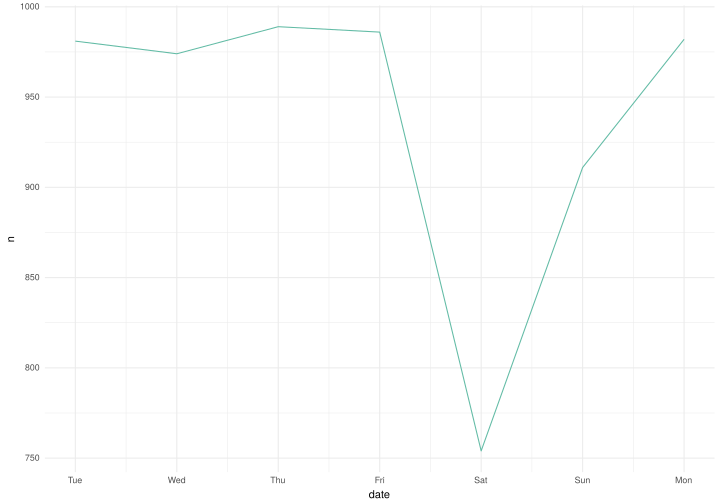

In [174]:
daily %>% filter(week(date) == 22) %>% ggplot(aes(x = date, y = n)) + 
    geom_line() + scale_x_date(date_labels = "%a", date_breaks = "1 day")

Another way to see this:

# A tibble: 365 x 3
   date           n wday 
   <date>     <int> <ord>
 1 2013-01-01   842 Tue  
 2 2013-01-02   943 Wed  
 3 2013-01-03   914 Thu  
 4 2013-01-04   915 Fri  
 5 2013-01-05   720 Sat  
 6 2013-01-06   832 Sun  
 7 2013-01-07   933 Mon  
 8 2013-01-08   899 Tue  
 9 2013-01-09   902 Wed  
10 2013-01-10   932 Thu  
# ... with 355 more rows


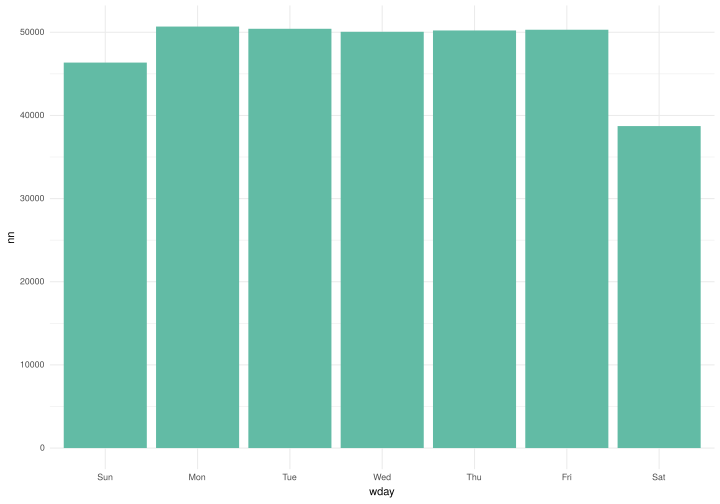

In [175]:
daily = daily %>% mutate(wday = wday(date, label = T)) %>% print
daily %>% count(wday, wt = n) %>% ggplot(aes(x = wday, y = nn)) + geom_col()

So, let's first regress out the weekday effect:

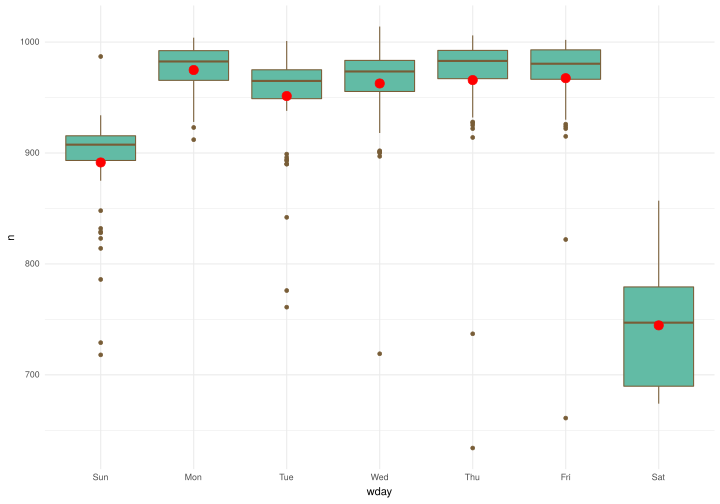

In [176]:
mod = lm(n ~ wday, data = daily)

grid = daily %>% data_grid(wday) %>% add_predictions(mod, "n")

ggplot(daily, aes(wday, n)) + 
  geom_boxplot() +
  geom_point(data = grid, colour = "red", size = 4)

Having removed the day-of-week effect, let's now re-examine the residuals:

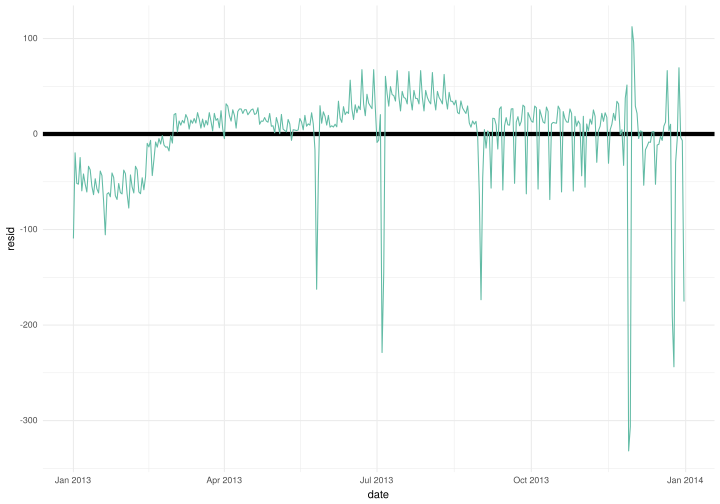

In [177]:
daily = daily %>% add_residuals(mod)
daily %>% ggplot(aes(date, resid)) + geom_ref_line(h = 0, colour = "black") + geom_line()

The $y$-axis now plots the deviation from the expected number of flights given the day of the week. This looks better but we still see quite a bit of structure in the data. Starting around June the model starts doing worse. In particular, there seems to be certain days that are extreme outliers, as indicated by the spikes. Let's see if we can figure out what those represent:

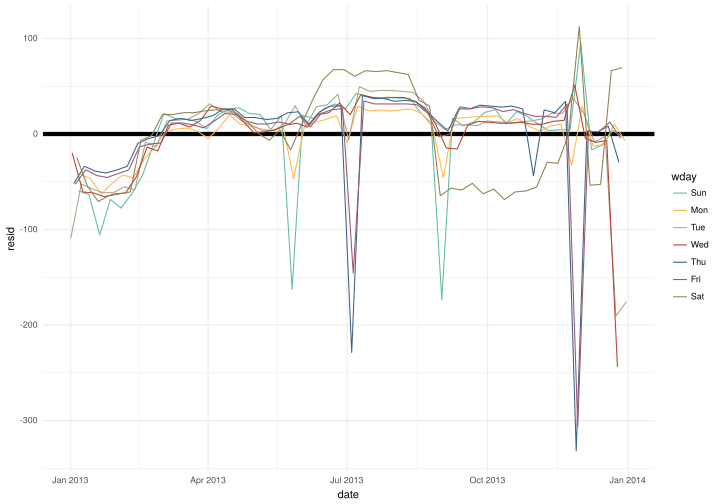

In [150]:
daily %>% ggplot(aes(date, resid, colour = wday)) + 
    geom_ref_line(h = 0, colour = "black") + geom_line()

Additionally, we have certain days with many fewer flights than expected:

In [147]:
daily %>% filter(resid < -100)

   date       n   wday resid    
1  2013-01-01 842 Tue  -109.3585
2  2013-01-20 786 Sun  -105.4808
3  2013-05-26 729 Sun  -162.4808
4  2013-07-04 737 Thu  -228.7500
5  2013-07-05 822 Fri  -145.4615
6  2013-09-01 718 Sun  -173.4808
7  2013-11-28 634 Thu  -331.7500
8  2013-11-29 661 Fri  -306.4615
9  2013-12-24 761 Tue  -190.3585
10 2013-12-25 719 Wed  -243.6923
11 2013-12-31 776 Tue  -175.3585

We recognize many of these as public holidays: New Year's, Thanksgiving, Christmas.

More generally, there is a seasonal trend whereby there are fewer daily flights than expected early and later in the year, and more than expected in the summer months:

`geom_smooth()` using method = 'loess'


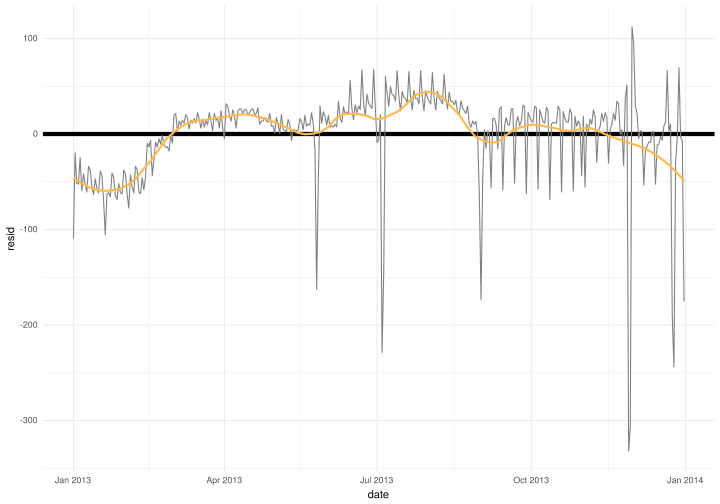

In [149]:
daily %>% ggplot(aes(date, resid)) + geom_ref_line(h = 0, colour = "black") + 
  geom_line(colour = "grey50") + 
  geom_smooth(se = FALSE, span = 0.20)

### Saturday effect
First we focus on capturing the "Saturday" effect. If we just look at Saturdays, we see that:

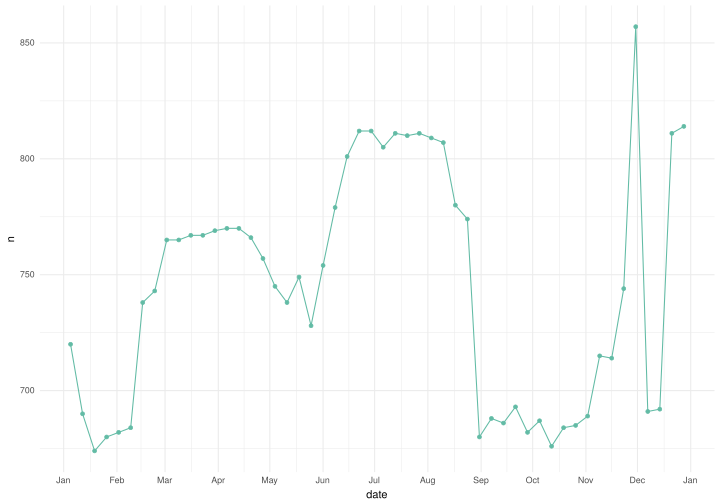

In [178]:
daily %>% filter(wday == "Sat") %>%  ggplot(aes(date, n)) + 
    geom_point() +  geom_line() + scale_x_date(date_breaks = "1 month", date_labels = "%b")

Let's try first to manually break this up into regions of approximately equal effect.

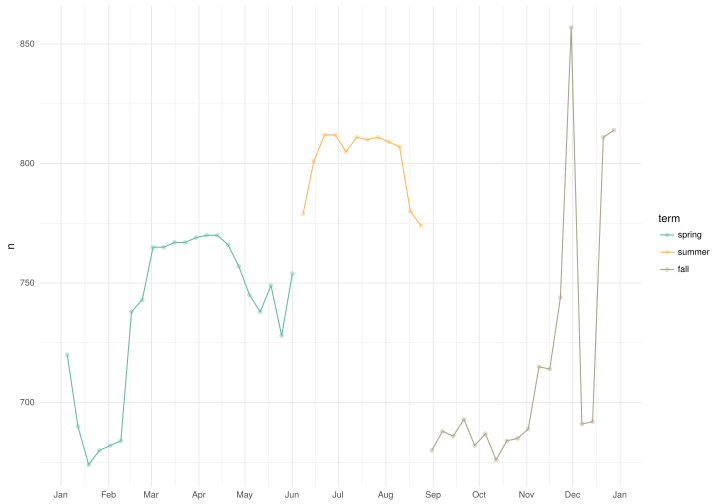

In [179]:
term <- function(date) {
  cut(date, 
    breaks = ymd(20130101, 20130605, 20130825, 20140101),
    labels = c("spring", "summer", "fall") 
  )
}

daily <- daily %>% 
  mutate(term = term(date)) 

daily %>% 
  filter(wday == "Sat") %>% 
  ggplot(aes(date, n, colour = term)) +
  geom_point(alpha = 1/3) + 
  geom_line() +
  scale_x_date(NULL, date_breaks = "1 month", date_labels = "%b")

Now we can compare how adding in this term effect changes our model fit:

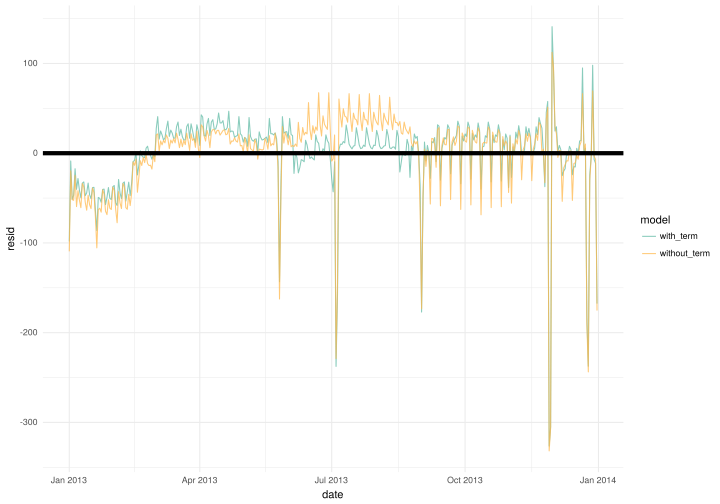

In [180]:
mod1 = lm(n ~ wday, data = daily)
mod2 = lm(n ~ wday * term, data = daily)

daily %>% gather_residuals(without_term = mod1, with_term = mod2) %>% 
  ggplot(aes(date, resid, colour = model)) + geom_line(alpha = 0.75) +
  geom_ref_line(h = 0, colour = "black") 

The fit looks better in the sense that the `with_term` line hews more closely to the reference line `resid=0`. But there are still a lot of big outliers that the model does not account for.

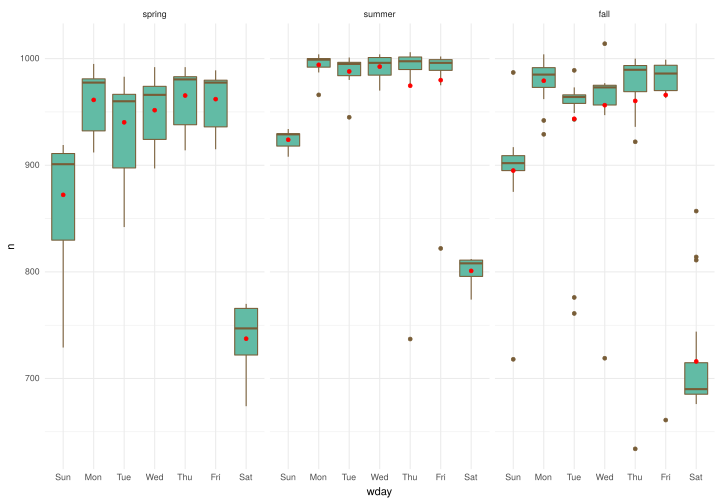

In [181]:
grid = daily %>% data_grid(wday, term) %>% add_predictions(mod2, "n")
ggplot(daily, aes(wday, n)) + geom_boxplot() + 
  geom_point(data = grid, colour = "red") + facet_wrap(~ term)

The red dots here represent the model predictions. Note the effect of the outliers (black dots) on the model predictions: they tend to drag the predictions towards them. This is especially evident in the fall months. This is another example of how the linear model can be susceptible to outliers. To counteract this, we can use a model that is more robust to outliers:

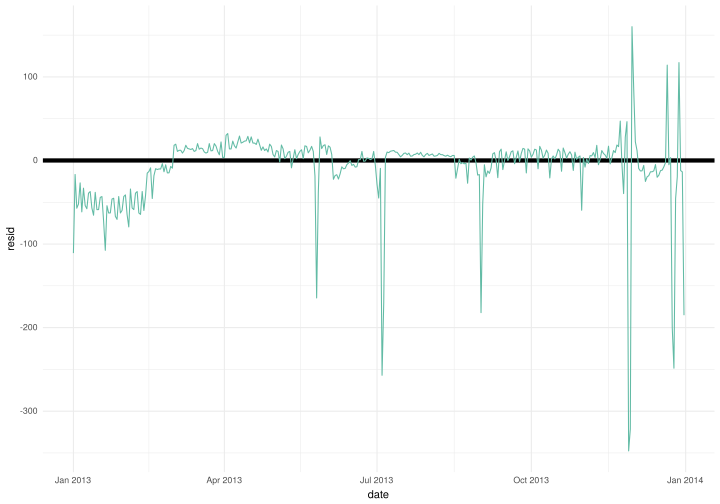

In [182]:
mod3 = MASS::rlm(n ~ wday * term, data = daily)
daily %>% add_residuals(mod3, "resid") %>% 
  ggplot(aes(date, resid)) + 
  geom_ref_line(h = 0, colour = "black") +
  geom_line()

This is looking much better. Except for a small winter effect, plus some outlying days in the summer and fall, the model now fits pretty well.

Lastly, we can go beyond the linear model and fit other types of models to these data:


Call: gam::gam(formula = n ~ wday * term + s(date), data = daily)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-321.141   -4.846    5.371   15.425  146.650 

(Dispersion Parameter for gaussian family taken to be 1774.815)

    Null Deviance: 3020698 on 364 degrees of freedom
Residual Deviance: 603437 on 340 degrees of freedom
AIC: 3792.657 

Number of Local Scoring Iterations: 2 

Anova for Parametric Effects
           Df  Sum Sq Mean Sq  F value    Pr(>F)    
wday        6 2170968  361828 203.8681 < 2.2e-16 ***
term        2   37016   18508  10.4282 4.023e-05 ***
s(date)     1   15221   15221   8.5760  0.003636 ** 
wday:term  12   37762    3147   1.7731  0.051288 .  
Residuals 340  603437    1775                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Anova for Nonparametric Effects
            Npar Df Npar F     Pr(F)    
(Intercept)                             
wday                                    
term                    

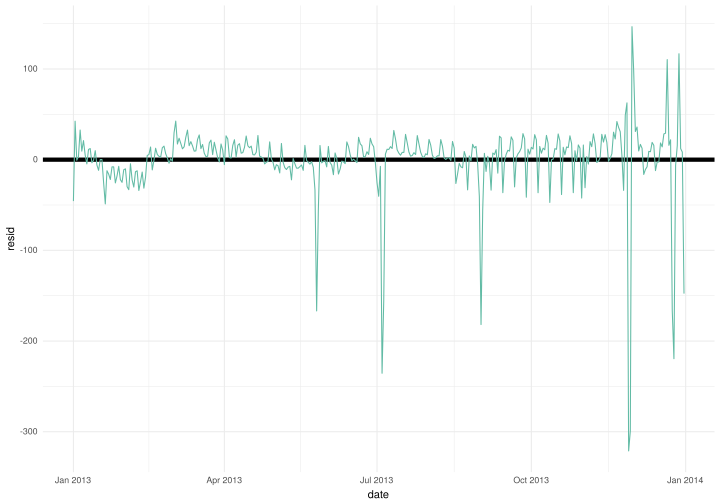

In [193]:
mod4 = gam::gam(n ~ wday * term + s(date), data = daily)
summary(mod4)
daily %>% add_residuals(mod4, "resid") %>% 
  ggplot(aes(date, resid)) + 
  geom_ref_line(h = 0, colour = "black") +
  geom_line()

## The `gapminder` data
We will start by looking at the "gapminder" data, which was popularised by Swedish statistician Hans Rosling. If you don't know about this data or this person, take five minutes and [watch one of his videos](http://r4ds.had.co.nz/many-models.html) before coming to lecture.

In [195]:
library(gapminder)
gapminder %>% print

# A tibble: 1,704 x 6
   country     continent  year lifeExp      pop gdpPercap
   <fctr>      <fctr>    <int>   <dbl>    <int>     <dbl>
 1 Afghanistan Asia       1952    28.8  8425333       779
 2 Afghanistan Asia       1957    30.3  9240934       821
 3 Afghanistan Asia       1962    32.0 10267083       853
 4 Afghanistan Asia       1967    34.0 11537966       836
 5 Afghanistan Asia       1972    36.1 13079460       740
 6 Afghanistan Asia       1977    38.4 14880372       786
 7 Afghanistan Asia       1982    39.9 12881816       978
 8 Afghanistan Asia       1987    40.8 13867957       852
 9 Afghanistan Asia       1992    41.7 16317921       649
10 Afghanistan Asia       1997    41.8 22227415       635
# ... with 1,694 more rows


To begin with we will focus on how life expectancy varies by year and by country.

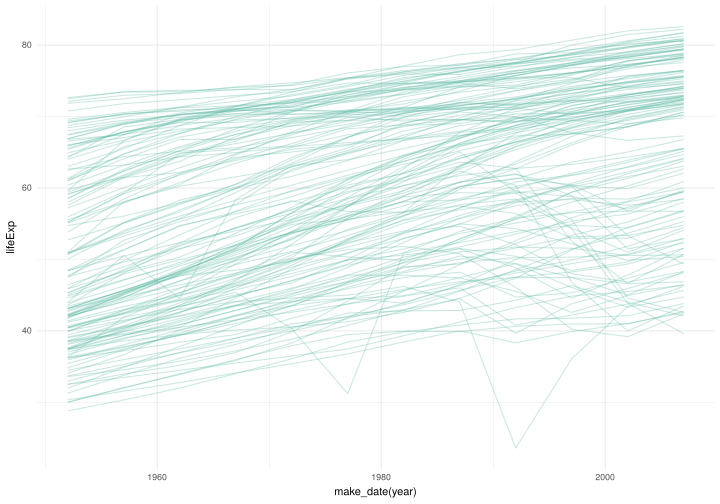

In [204]:
ggplot(gapminder, aes(x = make_date(year), y = lifeExp, group = country)) + 
    geom_line(alpha = 1/3) # add regression line

The regression line shows that overall trend in life expectancy has been upwards over the last fifty years. That's good! But there are some obvious exceptions. To cast those into sharper relief, let's subtract the linear trend from each series.

The linear trend is a good fit most of the non-African and non-Asian countries. However, beginning in the 1990s, a number of African countries have lagged far behind the rest of the world in terms of life expectancy. This is reflected in the negative residuals show in blue on the lower-right portion of this graph.

## Nested models
To dig deeper we will fit a separate linear model to each country. We'll first define a model function:

In [205]:
country_model <- function(df) {
  lm(lifeExp ~ year, data = df)
}

We want to fit this model to each country in our data frame. One option would be to use a for loop:

In [206]:
countries = unique(gapminder$country)
by_country = vector("list", length(countries))
for (i in seq_along(by_country)) {
    df = filter(gapminder, country == countries[[i]])
    by_country[[i]] = country_model(df)
}

As you might have guessed by now, we prefer to avoid this style of coding where possible. What we would like to be able to do is `map()` the `country_model()` function over a list of data frames, one per country. In order to do this we need a way to convert `gapminder` into series of data frames, one per country.

This is the purpose of the `nest()` command:

In [207]:
by_country = gapminder %>% group_by(country, continent) %>% nest %>% print

# A tibble: 142 x 3
   country     continent data             
   <fctr>      <fctr>    <list>           
 1 Afghanistan Asia      <tibble [12 × 4]>
 2 Albania     Europe    <tibble [12 × 4]>
 3 Algeria     Africa    <tibble [12 × 4]>
 4 Angola      Africa    <tibble [12 × 4]>
 5 Argentina   Americas  <tibble [12 × 4]>
 6 Australia   Oceania   <tibble [12 × 4]>
 7 Austria     Europe    <tibble [12 × 4]>
 8 Bahrain     Asia      <tibble [12 × 4]>
 9 Bangladesh  Asia      <tibble [12 × 4]>
10 Belgium     Europe    <tibble [12 × 4]>
# ... with 132 more rows


The `nest()` command has created a new `data` column. This column contains a copy of `gapminder`, filtered to contain only the rows that match the grouping variables. Thus:

In [208]:
by_country[1,] %>% print
by_country[[1, 3]] %>% print

# A tibble: 1 x 3
  country     continent data             
  <fctr>      <fctr>    <list>           
1 Afghanistan Asia      <tibble [12 × 4]>
# A tibble: 12 x 4
    year lifeExp      pop gdpPercap
   <int>   <dbl>    <int>     <dbl>
 1  1952    28.8  8425333       779
 2  1957    30.3  9240934       821
 3  1962    32.0 10267083       853
 4  1967    34.0 11537966       836
 5  1972    36.1 13079460       740
 6  1977    38.4 14880372       786
 7  1982    39.9 12881816       978
 8  1987    40.8 13867957       852
 9  1992    41.7 16317921       649
10  1997    41.8 22227415       635
11  2002    42.1 25268405       727
12  2007    43.8 31889923       975


Each of these rows is for Afghanistan, as can verify:

In [209]:
gapminder %>% filter(country == "Afghanistan")

   country     continent year lifeExp pop      gdpPercap
1  Afghanistan Asia      1952 28.801   8425333 779.4453 
2  Afghanistan Asia      1957 30.332   9240934 820.8530 
3  Afghanistan Asia      1962 31.997  10267083 853.1007 
4  Afghanistan Asia      1967 34.020  11537966 836.1971 
5  Afghanistan Asia      1972 36.088  13079460 739.9811 
6  Afghanistan Asia      1977 38.438  14880372 786.1134 
7  Afghanistan Asia      1982 39.854  12881816 978.0114 
8  Afghanistan Asia      1987 40.822  13867957 852.3959 
9  Afghanistan Asia      1992 41.674  16317921 649.3414 
10 Afghanistan Asia      1997 41.763  22227415 635.3414 
11 Afghanistan Asia      2002 42.129  25268405 726.7341 
12 Afghanistan Asia      2007 43.828  31889923 974.5803 

This is another example of a `list-column`, where we store R objects (which are lists plus additional attributes) inside of a data frame or tibble. We saw an example of this last lecture in the NCAA basketball example.

The nested data frame makes it easy to fit one model per country:

In [210]:
models = by_country$data %>% map(country_model)
models[[1]]


Call:
lm(formula = lifeExp ~ year, data = df)

Coefficients:
(Intercept)         year  
  -507.5343       0.2753  


However, it makes more sense to store the models inside of the `gap_n` table rather than leave them floating about.

In [211]:
by_country = by_country %>% mutate(model = map(data, country_model)) %>% print

# A tibble: 142 x 4
   country     continent data              model   
   <fctr>      <fctr>    <list>            <list>  
 1 Afghanistan Asia      <tibble [12 × 4]> <S3: lm>
 2 Albania     Europe    <tibble [12 × 4]> <S3: lm>
 3 Algeria     Africa    <tibble [12 × 4]> <S3: lm>
 4 Angola      Africa    <tibble [12 × 4]> <S3: lm>
 5 Argentina   Americas  <tibble [12 × 4]> <S3: lm>
 6 Australia   Oceania   <tibble [12 × 4]> <S3: lm>
 7 Austria     Europe    <tibble [12 × 4]> <S3: lm>
 8 Bahrain     Asia      <tibble [12 × 4]> <S3: lm>
 9 Bangladesh  Asia      <tibble [12 × 4]> <S3: lm>
10 Belgium     Europe    <tibble [12 × 4]> <S3: lm>
# ... with 132 more rows


By keeping the model, data frame, and country/continent all together, everything stays in sync when we alter the data in some way:

In [212]:
by_country %>% arrange(continent, country) %>% print

# A tibble: 142 x 4
   country                  continent data              model   
   <fctr>                   <fctr>    <list>            <list>  
 1 Algeria                  Africa    <tibble [12 × 4]> <S3: lm>
 2 Angola                   Africa    <tibble [12 × 4]> <S3: lm>
 3 Benin                    Africa    <tibble [12 × 4]> <S3: lm>
 4 Botswana                 Africa    <tibble [12 × 4]> <S3: lm>
 5 Burkina Faso             Africa    <tibble [12 × 4]> <S3: lm>
 6 Burundi                  Africa    <tibble [12 × 4]> <S3: lm>
 7 Cameroon                 Africa    <tibble [12 × 4]> <S3: lm>
 8 Central African Republic Africa    <tibble [12 × 4]> <S3: lm>
 9 Chad                     Africa    <tibble [12 × 4]> <S3: lm>
10 Comoros                  Africa    <tibble [12 × 4]> <S3: lm>
# ... with 132 more rows


Now we can add in the residuals that we sought to compute earlier:

In [213]:
by_country = mutate(by_country, resids = map2(data, model, add_residuals)) %>% print

# A tibble: 142 x 5
   country     continent data              model    resids           
   <fctr>      <fctr>    <list>            <list>   <list>           
 1 Afghanistan Asia      <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 2 Albania     Europe    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 3 Algeria     Africa    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 4 Angola      Africa    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 5 Argentina   Americas  <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 6 Australia   Oceania   <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 7 Austria     Europe    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 8 Bahrain     Asia      <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
 9 Bangladesh  Asia      <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
10 Belgium     Europe    <tibble [12 × 4]> <S3: lm> <tibble [12 × 5]>
# ... with 132 more rows


The inverse operation to `nest()` is `unnest()`. This takes a set of nested data frames and expands them back into a single, unnested dataframe:

In [214]:
resids = by_country %>% unnest(resids) %>% print

# A tibble: 1,704 x 7
   country     continent  year lifeExp      pop gdpPercap   resid
   <fctr>      <fctr>    <int>   <dbl>    <int>     <dbl>   <dbl>
 1 Afghanistan Asia       1952    28.8  8425333       779 -1.11  
 2 Afghanistan Asia       1957    30.3  9240934       821 -0.952 
 3 Afghanistan Asia       1962    32.0 10267083       853 -0.664 
 4 Afghanistan Asia       1967    34.0 11537966       836 -0.0172
 5 Afghanistan Asia       1972    36.1 13079460       740  0.674 
 6 Afghanistan Asia       1977    38.4 14880372       786  1.65  
 7 Afghanistan Asia       1982    39.9 12881816       978  1.69  
 8 Afghanistan Asia       1987    40.8 13867957       852  1.28  
 9 Afghanistan Asia       1992    41.7 16317921       649  0.754 
10 Afghanistan Asia       1997    41.8 22227415       635 -0.534 
# ... with 1,694 more rows


Now we can plot the residuals by country, as originally intended:

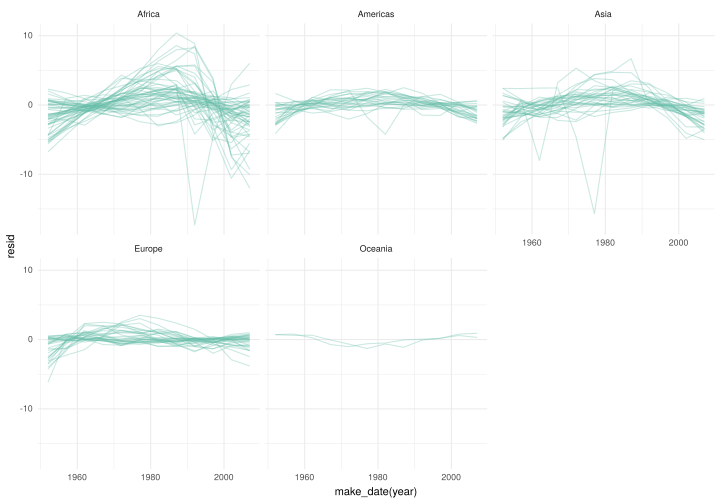

In [215]:
ggplot(resids, aes(x = make_date(year), y = resid, group = country)) + 
    geom_line(alpha = 1/3) + facet_wrap(~ continent)

Note that this is a roundabout way of getting the residuals by country. We could have just as easily fit a linear model with different slope and intercept terms for each country to get the same plot:

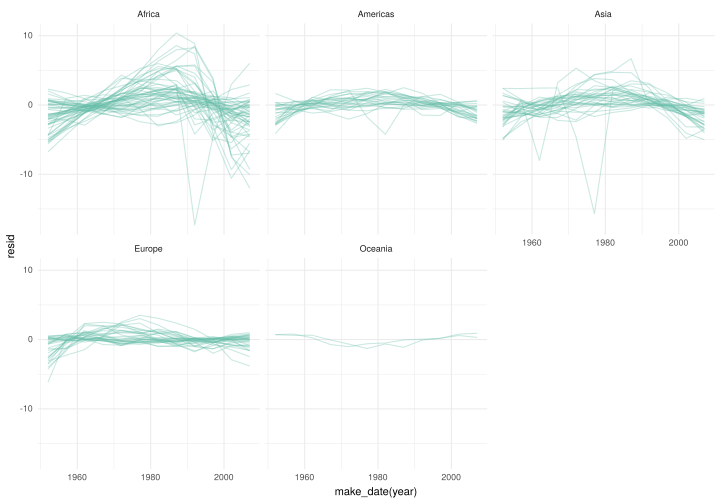

In [216]:
model = lm(lifeExp ~ year * country, gapminder)
gapminder %>% add_residuals(model) %>% ggplot(aes(x = make_date(year), y = resid, group = country)) + 
    geom_line(alpha = 1/3) + facet_wrap(~ continent) # add regression line

However, fitting a separate model for each country allows us to make other measurements of model quality, as we shall now see.

## Other measurements of model quality
So far we have looked at residuals to judge how well the models fit. There are other more general measurements of model quality. To help us look at these we will use the `broom` package for turning models into tidy data:

In [217]:
library(broom)


Attaching package: ‘broom’

The following object is masked from ‘package:modelr’:

    bootstrap



The `broom::glance()` function lets us quickly look at a model and judge how well it fits:

In [218]:
nz = gapminder %>% filter(country == "New Zealand")
nz_mod = lm(lifeExp ~ year, data = nz)
glance(nz_mod)

  r.squared adj.r.squared sigma     statistic p.value      df logLik   
1 0.9535846 0.9489431     0.8043472 205.4459  5.407324e-08 2  -13.32064
  AIC      BIC    deviance df.residual
1 32.64128 34.096 6.469743 10         

`glance` prints out some technical measurements of how well the model fits. The basic one is `r.squared`. In the simple linear model this simply measures the square of the correlation between the predictions $\hat{\mathbf{y}}$ and the observations $\mathbf{y}$:

In [45]:
nz %>% add_predictions(nz_mod) %>% summarize(r2 = cor(lifeExp, pred) ** 2)

  r2       
1 0.9535846

Using the commands we have learned so far, we can apply the glance function to each model in `by_country` in order to extract the $R^2$:

In [219]:
gl = by_country %>% mutate(glance = map(model, glance)) %>% 
                    unnest(glance, .drop = T) %>% print

# A tibble: 142 x 13
   country conti… r.squ… adj.r… sigma stati…   p.value    df logLik   AIC   BIC
   <fctr>  <fctr>  <dbl>  <dbl> <dbl>  <dbl>     <dbl> <int>  <dbl> <dbl> <dbl>
 1 Afghan… Asia    0.948  0.942 1.22   181    9.84e⁻ ⁸     2 -18.3  42.7  44.1 
 2 Albania Europe  0.911  0.902 1.98   102    1.46e⁻ ⁶     2 -24.1  54.3  55.8 
 3 Algeria Africa  0.985  0.984 1.32   662    1.81e⁻¹⁰     2 -19.3  44.6  46.0 
 4 Angola  Africa  0.888  0.877 1.41    79.1  4.59e⁻ ⁶     2 -20.0  46.1  47.5 
 5 Argent… Ameri…  0.996  0.995 0.292 2246    4.22e⁻¹³     2 - 1.17  8.35  9.80
 6 Austra… Ocean…  0.980  0.978 0.621  481    8.67e⁻¹⁰     2 -10.2  26.4  27.9 
 7 Austria Europe  0.992  0.991 0.407 1261    7.44e⁻¹²     2 - 5.16 16.3  17.8 
 8 Bahrain Asia    0.967  0.963 1.64   291    1.02e⁻ ⁸     2 -21.9  49.7  51.2 
 9 Bangla… Asia    0.989  0.988 0.977  930    3.37e⁻¹¹     2 -15.7  37.3  38.8 
10 Belgium Europe  0.995  0.994 0.293 1822    1.20e⁻¹²     2 - 1.20  8.40  9.85
# ... with 132 more

Plotting the resulting data, we see that most countries are fit pretty well by the linear model. But some countries, especially those in Africa, have a very bad fit:

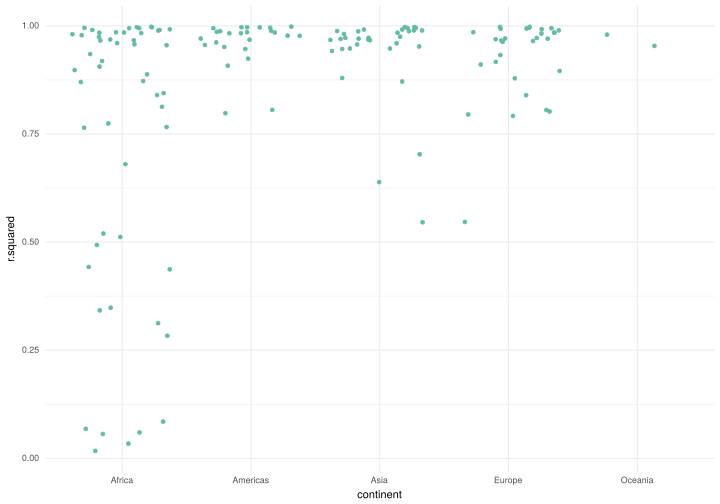

In [220]:
ggplot(gl, aes(x = continent, y = r.squared)) + geom_jitter()

Let's extract those for further analysis:

Joining, by = c("country", "continent")


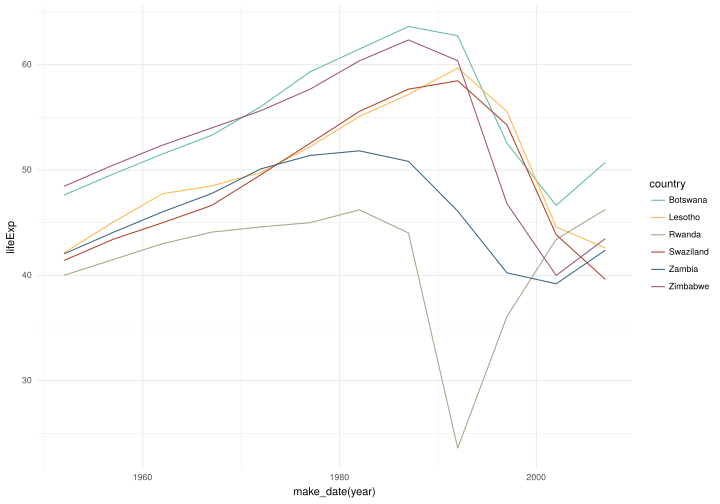

In [221]:
bad_fit = filter(gl, r.squared < 0.25)
gapminder %>% semi_join(bad_fit) %>% 
    ggplot(aes(make_date(year), lifeExp, color = country)) +
    geom_line()

There was a strong upward trend in life expectancy for 1950 to 1980 in these countries. Tragically, it was cut short in the 1990s. There are two reasons for this: the HIV/AIDS epidemic, and the Rwandan genocide.

This graph is really powerful. We can use the data to help us imagine what life would be like in these countries if not for these events:

In [222]:
afr = gapminder %>% semi_join(bad_fit) %>% group_by(country) %>% nest %>% 
      mutate(model = map(data, function(df) lm(lifeExp ~ year, df, subset = year < 1980)),
             pred_data = map2(data, model, function(df, m) add_predictions(df, m))) %>% 
      unnest(pred_data) %>% gather(prediction_type, lifeExp, lifeExp, pred) 

Joining, by = c("country", "continent")


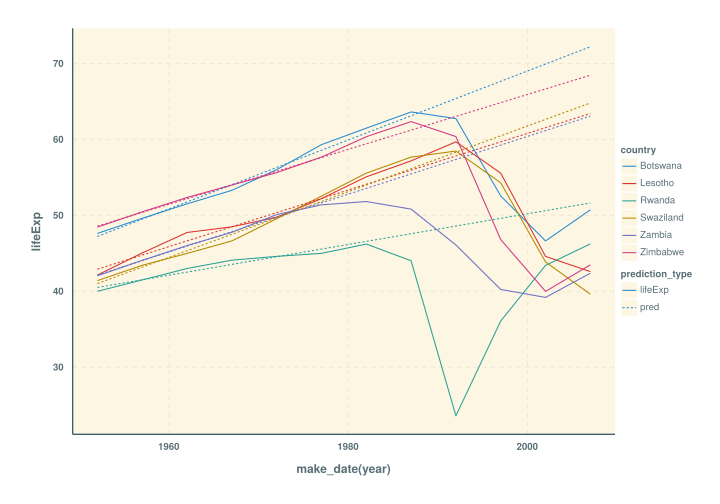

In [89]:
afr %>% ggplot(aes(x = make_date(year), y = lifeExp, color = country)) +
        geom_line(aes(linetype = prediction_type))

We predict that Botswana would now have had a life expectancy of about 75 years, on par with other developed countries.